## Goal: Compare Drug Sentiment from Paper Prescriptions

This solution is intended to provide more information to patients regarding the medication they receive.

Taking a dataset of unstructured text reviews of different drugs, Amazon Comprehend is used to understand the sentiment of the reviews and a function is created to compare sentiment across different drugs.

The solution tackles a second problem which is that of paper-based/handwritten prescriptions (still commonly used across various healthcare systems). Amazon Textract is used to extract text from photocopies or images of paper prescriptions and the **7Park Data** drug NER identifies the drug name in the unstructured text data. This then feeds the sentiment comparison lookup for an end-to-end solution.

### Pre-requisites

This sample notebook requires subscription to the following pre-trained machine learning model packages from AWS Marketplace:
 
**[Drug NER](https://aws.amazon.com/marketplace/pp/prodview-47xyf7s3glruu?qid=1575415914406&sr=0-5&ref_=srh_res_product_title)**

If your AWS account has not been subscribed to these listings, here is the process you can follow for each of the above mentioned listings:

1. Open the listing from AWS Marketplace
2. Read the **Highlights** section and then **product overview** section of the listing.
3. View **usage information** and then **additional resources.**
4. Note the supported instance types.
5. Next, click on **Continue to subscribe.
6. Review **End user license agreement, support terms**, as well as **pricing information.**
7. **\"Accept Offer\"** button needs to be clicked if your organization agrees with EULA, pricing information as well as support terms.

**Notes:**

If **Continue to configuration** button is active, it means your account already has a subscription to this listing. Once you click on **Continue to configuration** button and then choose region, you will see that a Product Arn will appear. This is the model package ARN that you need to specify while creating a deployable model. However, for this notebook, the algorithm ARN has been specified in **src/model_package_arns.py** file and you do not need to specify the same explicitly.

### Set up environment and view a sample image

Here we import the required libraries. Replace profile name and SageMaker IAM accordingly.

In [1]:
import boto3
import json
import sys
import pandas as pd
import wget
from zipfile import ZipFile

import sagemaker
from sagemaker import get_execution_role
from sagemaker import ModelPackage

from src.model_package_arns import ModelPackageArnProvider

session = boto3.Session(profile_name='jssandom')
sagemaker_session = sagemaker.Session(boto_session=session)

role = 'arn:aws:iam::068255676137:role/service-role/AmazonSageMaker-ExecutionRole-20200410T172127'

We can use matplotlib to load our example prescription image.

Populating the interactive namespace from numpy and matplotlib


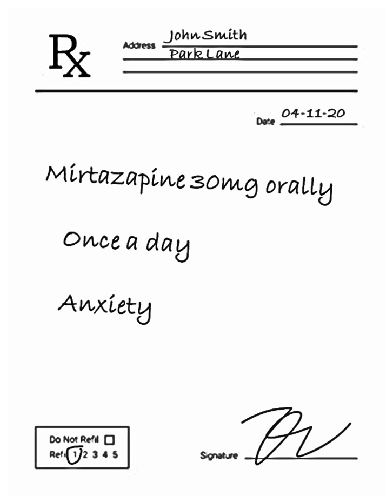

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 9))

img_path = 'data/Prescription Example.png'

img=mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Step 1: Load and Prepare Drug Review Data

The data used to create sentiment scores is taken from the well known **[Drug Review Dataset](http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)** from the UCI Machine Learning Repository.

It contains patient reviews on specific drugs along with related conditions.

### Step 1.1: Download and load the drug review dataset

In [3]:
print('Beginning file download with wget module')

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip'
wget.download(url, './data/drugsCom_raw.zip')

Beginning file download with wget module
100% [........................................................................] 42989872 / 42989872

'./data/drugsCom_raw (1).zip'

In [4]:
with ZipFile('data/drugsCom_raw.zip', 'r') as zipObj:
    # Extract the zip file contents in the current directory
    zipObj.extractall('data')

In [5]:
reviews = pd.read_csv('data/drugsComTrain_raw.tsv', delimiter='\t')
reviews.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


### Step 1.2: Clean and Prepare the Data

In [6]:
# Remove columns we don't need

reviews = reviews[['drugName', 'condition', 'review']]
len(reviews)

161297

In [7]:
# Remove nulls or invalid conditions

reviews = reviews.dropna()
reviews = reviews[~reviews.condition.str.contains('</span')]

Amazon Comprehend requires document size to be less than 5,000 bytes for sentiment analysis so we remove any reviews that are longer.

In [8]:
for index, row in reviews.iterrows():
    size = sys.getsizeof(row['review'])
    if size >= 5000:
        reviews.drop(index, inplace=True)

len(reviews)

159489

Our data is quite large and there are lots of drugs with only a few reviews as well as conditions which only have a small number of drugs for comparison.

To reduce size, we filter our data by drugs which have **100** or more reviews and then conditions which have at least **10** of these drugs for comparison.

In [9]:
# Drugs with 100 or more reviews

reviews = reviews.groupby(['drugName', 'condition']).filter(lambda group: len(group) >= 100)
len(reviews)

89319

In [10]:
# Conditions with 10 or more drugs

reviews = reviews.groupby('condition').filter(lambda x: x['drugName'].nunique() >= 10)
len(reviews)

57225

In [11]:
reviews.head()

,drugName,condition,review
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ..."
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth..."
7,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was..."
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m..."
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have..."


## Step 2: Perform Sentiment Analysis with Amazon Comprehend

In this section, we use Amazon Comprehend to find the *sentiment* of each review and also return the positive sentiment score.

We then use our results to create lookup tables for our comparison function.

### Step 2.1: Generate Sentiment

In [12]:
comprehend = session.client(service_name='comprehend')

In [13]:
# Define a function to generate sentiment using Batch Detect Sentiment

def sentiment_generator(lst):

    sentiment = []
    positivity_score = []

    # Create successive 25-sized chunks from list for batch detect sentiment
    text_lists = [lst[i:i + 25] for i in range(0, len(lst), 25)]
    
    print("Beginning sentiment detection on {} batches".format(len(text_lists)))

    for num, text_list in enumerate(text_lists):
        batch_sentiment = comprehend.batch_detect_sentiment(TextList=text_list, LanguageCode='en')['ResultList']
        for i in range(len(batch_sentiment)):
            sentiment.append(batch_sentiment[i]['Sentiment'])
            positivity_score.append(round(batch_sentiment[i]['SentimentScore']['Positive'], 2))
        if num % 50 == 0:
            print("......Completed {} batches......".format(num))

    print("Finished sentiment detection".format(len(text_lists)))
    
    return sentiment, positivity_score

The following blocks of code are used to generate the sentiment scores and create a data frame of reviews sentiment. We have blocked out the code as there are some costs to run Amazon Comprehend.

Instead of re-running Comprehend, we can read in the resulting *reviews_sentiment.csv*.

In [14]:
#sentiment, positivityScore = sentiment_generator(reviews.review.values.tolist())

In [15]:
#reviews_sentiment = reviews
#reviews_sentiment['sentiment'] = sentiment
#reviews_sentiment['positivityScore'] = positivityScore

#reviews_sentiment.head()

In [16]:
#reviews_sentiment.to_csv('data/reviews_sentiment.csv')

In [17]:
reviews_sentiment = pd.read_csv('data/reviews_sentiment.csv', index_col=0)

### Step 2.2: Create Aggregated Lookup Tables

In order to return the review sentiment counts and positive sentiment scores, we create a 'lookup table' which aggregates the sentiment counts and average positivity score by drug.

In [18]:
# Average positivity score by drug

avg_pos_score = reviews_sentiment.groupby('drugName').median()
avg_pos_score = avg_pos_score.rename(columns={"positivityScore": "medianPositivityScore"})

# Count of sentiment by drug

count_sentiments = reviews_sentiment[['drugName', 'sentiment']].pivot_table(index='drugName', columns='sentiment', 
                                                                            aggfunc=len, fill_value=0)

count_sentiments.reset_index(drop=False, inplace=False)

# Change to percentages

count_sentiments = round(count_sentiments.div(count_sentiments.sum(axis=1), axis=0).multiply(100), 2)
count_sentiments = count_sentiments.rename(columns={"MIXED": "mixedPct", 
                                                    "NEGATIVE": "negativePct", 
                                                    "NEUTRAL": "neutralPct", 
                                                    "POSITIVE": "positivePct"})

count_sentiments.reset_index(drop=False, inplace=False)

# Merge tables

reviews_sentiment_by_drug = avg_pos_score.merge(count_sentiments, on='drugName').reset_index()


reviews_sentiment_by_drug.head()

,drugName,medianPositivityScore,mixedPct,negativePct,neutralPct,positivePct
0,Abilify,0.80,1.37,29.79,5.14,63.70
1,Accutane,0.87,0.00,23.99,1.87,74.14
2,Acetaminophen / hydrocodone,0.79,0.90,22.59,6.02,70.48
3,Acetaminophen / oxycodone,0.86,0.80,15.66,5.62,77.91
4,Aczone,0.87,0.00,23.26,3.88,72.87


Then we create a second lookup table which finds the sentiment counts and average positivity score by condition **and** drug. This is so we can find the best rated drugs for different conditions

In [19]:
# Average positivity score by drug and condition
avg_pos_score = reviews_sentiment.groupby(['condition', 'drugName']).median()
avg_pos_score = avg_pos_score.rename(columns={"positivityScore": "medianPositivityScore"})

# Count of sentiment by drug
count_sentiments = reviews_sentiment[['condition', 'drugName', 'sentiment']].pivot_table(index=['condition','drugName'], 
                                                                                         columns='sentiment', 
                                                                                         aggfunc=len, fill_value=0)

count_sentiments.reset_index(drop=False, inplace=False)

# Change to percentages
count_sentiments = round(count_sentiments.div(count_sentiments.sum(axis=1), axis=0).multiply(100), 2)
count_sentiments = count_sentiments.rename(columns={"MIXED": "mixedPct", 
                                                    "NEGATIVE": "negativePct", 
                                                    "NEUTRAL": "neutralPct", 
                                                    "POSITIVE": "positivePct"})

count_sentiments.reset_index(drop=False, inplace=False)

# Merge tables
reviews_sentiment_by_condition_drug = avg_pos_score.merge(count_sentiments, on=['condition','drugName']).reset_index()


reviews_sentiment_by_condition_drug.head()

,condition,drugName,medianPositivityScore,mixedPct,negativePct,neutralPct,positivePct
0,ADHD,Adderall,0.87,0.62,18.12,4.38,76.88
1,ADHD,Adderall XR,0.91,0.00,14.95,4.67,80.37
2,ADHD,Amphetamine / dextroamphetamine,0.85,0.57,20.68,4.82,73.94
3,ADHD,Atomoxetine,0.69,0.49,36.45,2.96,60.10
4,ADHD,Concerta,0.84,0.00,24.74,4.74,70.53


### Step 2.3: Define Sentiment Results Function

Now we can create our function which returns a report based on a drug name input and the previous lookup tables.

In [20]:
def sentiment_results(drug_name, by_drug_df, by_condition_drug_df):
    
    # Return scores for all drug reviews
    mps = float(by_drug_df[by_drug_df.drugName == drug_name].medianPositivityScore)
    pos = float(by_drug_df[by_drug_df.drugName == drug_name]['positivePct'])
    neg = float(by_drug_df[by_drug_df.drugName == drug_name]['negativePct'])
    mix = float(by_drug_df[by_drug_df.drugName == drug_name]['mixedPct'])
    neu = float(by_drug_df[by_drug_df.drugName == drug_name]['neutralPct'])
    
    print('##############################################################################################')
    print()
    print()
    
    print('********************* {} has a median positivity score of {} **********************'.format(drug_name, mps))
    print()
    print('--------------------- {} % of patient reviews have positive sentiment ---------------------'.format(pos))
    print('--------------------- {} % of patient reviews have negative sentiment ---------------------'.format(neg))
    print('----------------------- {} % of patient reviews have mixed sentiment -----------------------'.format(mix))
    print('---------------------- {} % of patient reviews have neutral sentiment ----------------------'.format(neu))
    
    print()
    print()
    
    # Find conditions where the drug is applied
    
    # sort by_condition_drug_df
    by_condition_drug_df = by_condition_drug_df.sort_values(by=['condition','medianPositivityScore'], ascending=False)
    
    conditions = by_condition_drug_df[by_condition_drug_df.drugName == drug_name].condition
    
    for condition in conditions:
        # Find score for input drug
        condition_mps = float(by_condition_drug_df[(by_condition_drug_df.condition == condition)
                                             & (by_condition_drug_df.drugName == drug_name)].medianPositivityScore)
        
        condition_top_3 = by_condition_drug_df[by_condition_drug_df.condition == condition][:3].reset_index()
        
        print()
        print("{} has a positivity of {} for patients needing it for {}.".format(drug_name, condition_mps, condition))
        print()
        print("The following other drugs had a higher positivity score for {}:".format(condition))
        for index, row in condition_top_3.iterrows():
            if row['drugName'] == drug_name and index == 0:
                print("- No other drug had a higher positive sentiment score")
                break
            elif row['drugName'] != drug_name:
                print("- {} ({})".format(row['drugName'], row['medianPositivityScore']))
            else:
                break
        print()
                
    print()
    print('##############################################################################################')

Let's test the function on an example drug - *Belsomra*.

In [21]:
sentiment_results('Belsomra', reviews_sentiment_by_drug, reviews_sentiment_by_condition_drug)

##############################################################################################


********************* Belsomra has a median positivity score of 0.23 **********************

--------------------- 40.74 % of patient reviews have positive sentiment ---------------------
--------------------- 53.97 % of patient reviews have negative sentiment ---------------------
----------------------- 0.0 % of patient reviews have mixed sentiment -----------------------
---------------------- 5.29 % of patient reviews have neutral sentiment ----------------------



Belsomra has a positivity of 0.23 for patients needing it for Insomnia.

The following other drugs had a higher positivity score for Insomnia:
- Mirtazapine (0.93)
- Amitriptyline (0.89)
- Quetiapine (0.86)


##############################################################################################


## Step 3: Extract Text from Image with Textract

In this section, we simply define a function that reads in an image file and returns the lines of text within.

### Step 3.1: Define text from image function

In [22]:
textract = session.client('textract')

In [23]:
def text_from_img(image_path):
    # read image as bytes object
    with open(image_path, "rb") as image:
        b = bytearray(image.read())
        
    response = textract.detect_document_text(
    Document={
        'Bytes': b
    })
    
    text_list = []
    
    for block in response['Blocks']:
        if (block['BlockType'] == 'LINE'):
            text_list.append(block['Text'])
            
    return text_list

## Step 4: Use Drug Name NER to Extract the Drug Name

In this section, we deploy the Drug Name NER model and create an endpoint for real-time inference.

We then define a function which returns a list of drug names from the lines of text produced by Amazon Textract.

### Step 4.1: Deploy the model for performing real-time inference

In [24]:
# Get the model_package_arn
modelpackage_arn = ModelPackageArnProvider.get_model_package_arn(sagemaker_session.boto_region_name)

# Define predictor wrapper class
def ner_detection_predict_wrapper(endpoint, session):
    return sagemaker.RealTimePredictor(endpoint, session, content_type='application/json')

# Create a deployable model package
ner_model = ModelPackage(role=role,
                         model_package_arn=modelpackage_arn,
                         sagemaker_session=sagemaker_session,
                         predictor_cls=ner_detection_predict_wrapper)

# Deploy the model
ner_predictor = ner_model.deploy(initial_instance_count=1, 
                                 instance_type='ml.m5.xlarge',
                                 endpoint_name='drug-ner-endpoint')

-----------------!

### Step 4.2: Define Function for extracting drug name

In [25]:
def drug_finder(img_text_list):

    for img_text in img_text_list:

        sample = {'instance': img_text}

        drug_list = []

        # Perform a prediction
        ner_result = ner_predictor.predict(json.dumps(sample)).decode('utf-8')

        # Append drugs to result

        if len(json.loads(ner_result)['ner']) > 0:
            drug_list.append(json.loads(ner_result)['ner'][0]['key'])
        else:
            continue

        return drug_list

## Step 5: Run End-to-end Solution

Finally, we can bring it all together.

### Step 5.1: Function which combines previous steps

In [26]:
def drug_sentiment_checker(img_path, lookup_by_drug, lookup_by_condition_drug):
    
    # extract text from image
    text_list = text_from_img(img_path)
    
    # extract drug name(s) from text
    drug_list = drug_finder(text_list)
    
    # check sentiment
    for drug in drug_list:
        sentiment_results(drug, 
                          lookup_by_drug, 
                          lookup_by_condition_drug)

### Step 5:2: Get sentiment result from example prescription image

In [27]:
drug_sentiment_checker(img_path, reviews_sentiment_by_drug, reviews_sentiment_by_condition_drug)

##############################################################################################


********************* Mirtazapine has a median positivity score of 0.89 **********************

--------------------- 70.95 % of patient reviews have positive sentiment ---------------------
--------------------- 23.16 % of patient reviews have negative sentiment ---------------------
----------------------- 0.84 % of patient reviews have mixed sentiment -----------------------
---------------------- 5.05 % of patient reviews have neutral sentiment ----------------------



Mirtazapine has a positivity of 0.93 for patients needing it for Insomnia.

The following other drugs had a higher positivity score for Insomnia:
- No other drug had a higher positive sentiment score


Mirtazapine has a positivity of 0.85 for patients needing it for Depression.

The following other drugs had a higher positivity score for Depression:
- Wellbutrin XL (0.91)
- Desvenlafaxine (0.88)
- Citalopram (0.87)


Mir

### Cleanup

In [28]:
ner_predictor.delete_endpoint()
ner_predictor.delete_model()

Finally, if the AWS Marketplace subscription was created just for an experiment and you would like to unsubscribe, here are the steps that can be followed. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model.

**Steps to unsubscribe from the product on AWS Marketplace:**

Navigate to Machine Learning tab on Your [Software subscriptions page](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=lbr_tab_ml).
Locate the listing that you would need to cancel, and click Cancel Subscription.